In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo, TimeDelta
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst_efd_client import EfdClient
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Description
### Grab data for single oscillation event
 - hardpoint forces
 - azimuth telemetry
 - elevation telemetry

### plot all telemetry compare efdStamp with timestamp fields

In [3]:
client = makeEfdClient()
# Select data from a given date
dayObs = 20230627
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
event_time=Time("2023-06-27 12:10:17.733")


In [6]:
#identify slewnum from tmaEventMaker
for slew in slews:
    if (slew.begin < event_time) & ( slew.end > event_time):
        print(slew)
        event_slew=slew

dayObs: 20230627
seqNum: 0
type: SLEWING
endReason: STOPPED
duration: 361.5136876106262
begin: <Time object: scale='tai' format='unix_tai' value=1687867593.9669485>,
end: <Time object: scale='tai' format='unix_tai' value=1687867955.4806361>
beginFloat: 1687867593.9669485
endFloat: 1687867955.4806361


### query data 

In [11]:
prePadding=5
df_m1m3_hp=getEfdData(client,"lsst.sal.MTM1M3.hardpointActuatorData",  
                        begin=event_time, 
                        end=event_time, 
                        prePadding=prePadding, 
                        postPadding=4)
df_mtmount_azimuth=getEfdData(client,"lsst.sal.MTMount.azimuth",
                       begin=event_time, 
                        end=event_time, 
                        prePadding=prePadding, 
                        postPadding=4)
df_mtmount_elevation=getEfdData(client,"lsst.sal.MTMount.elevation",
                       begin=event_time, 
                        end=event_time, 
                        prePadding=prePadding, 
                        postPadding=4)

### Plot everything

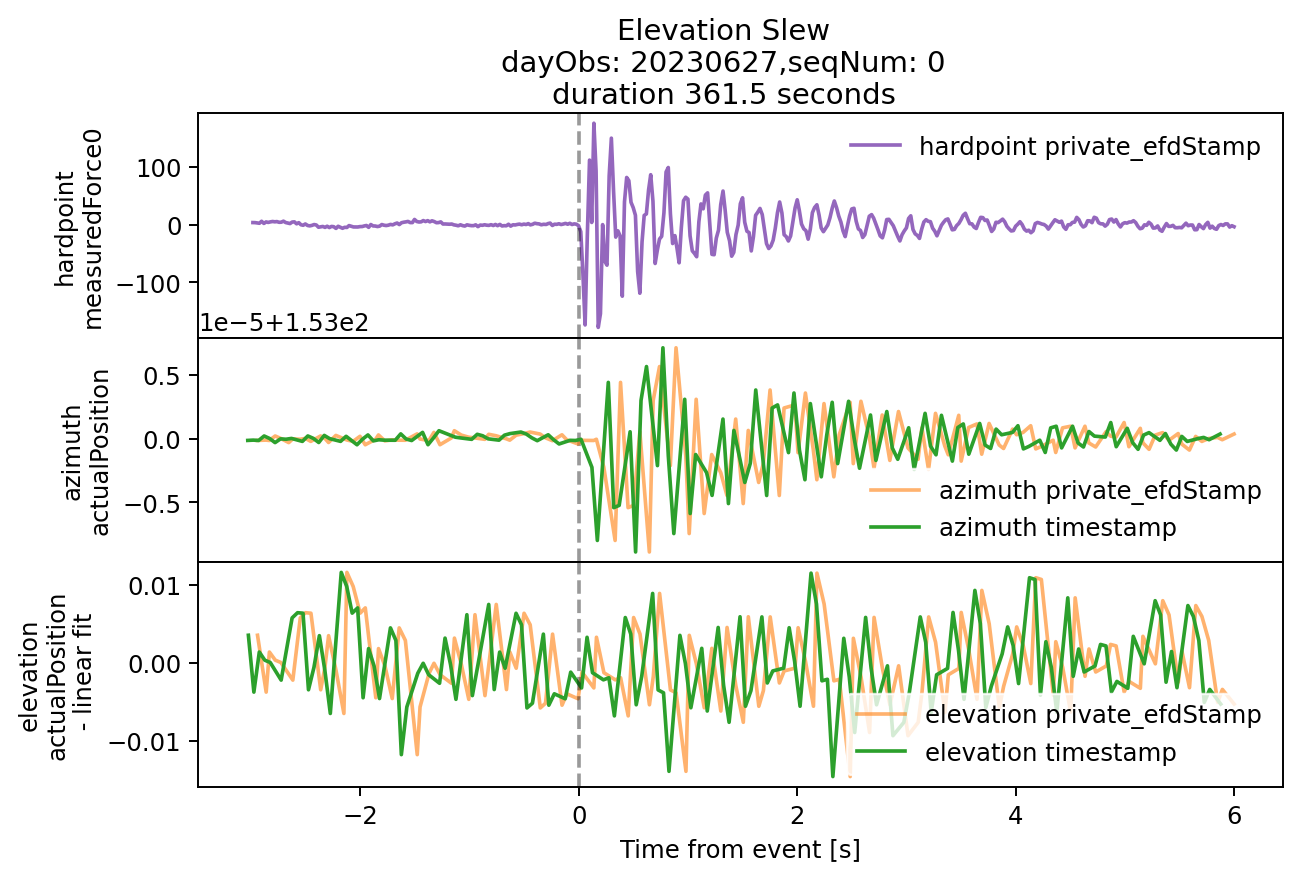

In [13]:
fig, axs = plt.subplots(3, dpi=175, sharex=True, figsize=(8,5))
plt.suptitle(f"Elevation Slew\ndayObs: {event_slew.dayObs},"+
             f"seqNum: {event_slew.seqNum}\nduration {event_slew.duration:0.1f} seconds", y=0.99)
ax=axs[0]
times_hp=Time(df_m1m3_hp["private_efdStamp"], format="unix").unix - event_time.unix + 2
ax.plot(times_hp, df_m1m3_hp["measuredForce0"], label="hardpoint private_efdStamp", color="tab:purple")
ax.legend(edgecolor="white")
ax.axvline(0,ls="dashed", alpha=0.4, c="k")
ax.set_ylabel("hardpoint\nmeasuredForce0")

ax=axs[1]
ax.axvline(0,ls="dashed", alpha=0.4, c="k")
times_azimuth_1=Time(df_mtmount_azimuth["private_efdStamp"], format="unix").unix - event_time.unix + 2
times_azimuth_2=Time(df_mtmount_azimuth["timestamp"], format="unix_tai").unix - event_time.unix + 2
ax.plot(times_azimuth_1, df_mtmount_azimuth["actualPosition"], color="tab:orange", label="azimuth private_efdStamp", alpha=0.6)
ax.plot(times_azimuth_2, df_mtmount_azimuth["actualPosition"], color="tab:green", label="azimuth timestamp")
ax.legend(edgecolor="white")

ax.set_ylabel("azimuth\nactualPosition")

ax=axs[2]
times_elevation_1=Time(df_mtmount_elevation["private_efdStamp"], format="unix").unix - event_time.unix + 2
times_elevation_2=Time(df_mtmount_elevation["timestamp"], format="unix_tai").unix - event_time.unix + 2
elevation_fit=np.polyfit(times_elevation_1, df_mtmount_elevation["actualPosition"], 1)
detrend_elevaton= df_mtmount_elevation["actualPosition"] - np.polyval(elevation_fit, times_elevation_1)
ax.plot(times_elevation_1, detrend_elevaton, color="tab:orange", label="elevation private_efdStamp", alpha=0.6)
ax.plot(times_elevation_2, detrend_elevaton, color="tab:green", label="elevation timestamp")
ax.axvline(0,ls="dashed", alpha=0.4, c="k")
ax.legend(edgecolor="white")
ax.set_ylabel("elevation\nactualPosition\n - linear fit")
ax.set_xlabel("Time from event [s]")
plt.subplots_adjust(hspace=0)

plt.savefig("../plots/tma_osc.png")